In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install torch==1.5.0  torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html



Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 29kB/s 
     |████████████████████████████████| 6.5MB 71.5MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys
import glob
from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.5.0+cu92
0.6.0+cu92


In [ ]:
MODEL_NAME = 'R1'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_DIM = (64, 64, 3)

In [ ]:
def tensor2img(tensor):
    img = (np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.
    # img = (1/(2*2.25)) * old + 0.5
    return img

def get_sample_image(G, n_noise=100, n_samples=64):
    """
        save sample 64 images
    """
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(DEVICE) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return result


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None, groups=1):
        super(ResidualBlock, self).__init__()
        p = kernel_size//2
        self.conv1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size, stride=stride, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.proj = nn.Conv2d(inplanes, planes, 1) if inplanes != planes else None
    
    def forward(self, x):
        identity = x
        
        y = self.conv1(x)
        y = self.conv2(y)
        
        identity = identity if self.proj is None else self.proj(identity)
        y = y + identity
        return y

In [ ]:

class Discriminator(nn.Module):
    """
        Convolutional Discriminator
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1), # (N, 64, 64, 64)
            ResidualBlock(64, 128),
            nn.AvgPool2d(3, 2, padding=1), # (N, 128, 32, 32)
            ResidualBlock(128, 256),
            nn.AvgPool2d(3, 2, padding=1), # (N, 256, 16, 16)
            ResidualBlock(256, 512),
            nn.AvgPool2d(3, 2, padding=1), # (N, 512, 8, 8)
            ResidualBlock(512, 1024),
            nn.AvgPool2d(3, 2, padding=1) # (N, 1024, 4, 4)
        )
        self.fc = nn.Linear(1024*4*4, 1) # (N, 1)
        
    def forward(self, x):
        B = x.size(0)
        h = self.D(x)
        h = h.view(B, -1)
        y = self.fc(h)
        return y

class Generator(nn.Module):
    """
        Convolutional Generator
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=512):
        super(Generator, self).__init__()
        self.fc = nn.Linear(n_noise, 1024*4*4)
        self.G = nn.Sequential(
            ResidualBlock(1024, 512),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 512, 8, 8)
            ResidualBlock(512, 256),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 256, 16, 16)
            ResidualBlock(256, 128),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 128, 32, 32)
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 64, 64, 64)
            ResidualBlock(64, 64),
            nn.Conv2d(64, out_channel, 3, padding=1) # (N, 3, 64, 64)
        )
        
    def forward(self, z):
        B = z.size(0)
        h = self.fc(z)
        h = h.view(B, 1024, 4, 4)
        x = self.G(h)
        return x

In [ ]:
transform = transforms.Compose(
[transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=(0.5, 0.5, 0.5),
#                                 std=(0.5, 0.5, 0.5))
#                                ]
# )


In [ ]:
dataset= datasets.ImageFolder(root="/content/drive/My Drive/Colab Notebooks/EVA_P2/S6",transform=transform)


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 347
    Root location: /content/drive/My Drive/Colab Notebooks/EVA_P2/S6
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
batch_size=32

**Loading data to train and test loader**

In [ ]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(111)

if cuda:
    torch.cuda.manual_seed(111)

    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=4)


CUDA Available? True


In [ ]:
n_noise = 256

In [ ]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1], n_noise=n_noise).to(DEVICE)

**Building model network**

In [ ]:
D_opt = torch.optim.RMSprop(D.parameters(), lr=1e-4, alpha=0.99)
G_opt = torch.optim.RMSprop(G.parameters(), lr=1e-4, alpha=0.99)

In [ ]:
def r1loss(inputs, label=None):
    # non-saturating loss with R1 regularization
    l = -1 if label else 1
    return F.softplus(l*inputs).mean()

In [ ]:
max_epoch = 20
step = 0

log_term = 1000
save_term = 1000
r1_gamma = 10


steps_per_epoch = len(trainloader.dataset) // batch_size
steps_per_epoch



10

In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/EVA_P2/S6'

/content/drive/My Drive/Colab Notebooks/EVA_P2/S6


In [ ]:
if not os.path.exists('samples'):
    os.makedirs('samples')
    
if not os.path.exists('ckpt'):
    os.makedirs('ckpt')

def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
max_epoch = 1000

In [ ]:
Dtrain_loss=0
Gtrain_loss=0

Dtrain_losses=[]
Gtrain_losses=[]

import warnings
warnings.filterwarnings("ignore")

for epoch in range(max_epoch):
    print("Epoch: ",epoch)
    for images, labels in trainloader:
        G.zero_grad()
        # Training Discriminator
        x = images.to(DEVICE)
        x.requires_grad = True
        x_outputs = D(x)
        d_real_loss = r1loss(x_outputs, True)
        
        grad_real = grad(outputs=x_outputs.sum(), inputs=x, create_graph=True)[0]
        grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty = 0.5*r1_gamma*grad_penalty
        D_x_loss = d_real_loss + grad_penalty

        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake.detach())
        D_z_loss = r1loss(z_outputs, False)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        Dtrain_loss += D_loss.item()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake)
        G_loss = r1loss(z_outputs, True)
        
        G.zero_grad()
        Gtrain_loss += G_loss.item()
        G_loss.backward()
        G_opt.step()
        
        
    Dtrain_loss /=len(images)
    Gtrain_loss /=len(images)
    Dtrain_losses.append(Dtrain_loss)
    Gtrain_losses.append(Gtrain_loss)
    
    print('\nDtrain_losses: {:.4f}, Gtrain_losses:{:.4f}'.format(Dtrain_loss,Gtrain_loss))  
    print()

Epoch:  0

Dtrain_losses: 0.1773, Gtrain_losses:1.3293

Epoch:  1

Dtrain_losses: 0.1320, Gtrain_losses:1.7387

Epoch:  2

Dtrain_losses: 0.4047, Gtrain_losses:0.9750

Epoch:  3

Dtrain_losses: 0.2128, Gtrain_losses:1.3259

Epoch:  4

Dtrain_losses: 0.1790, Gtrain_losses:1.7334

Epoch:  5

Dtrain_losses: 0.1962, Gtrain_losses:1.5236

Epoch:  6

Dtrain_losses: 0.1332, Gtrain_losses:1.4376

Epoch:  7

Dtrain_losses: 0.4449, Gtrain_losses:1.2644

Epoch:  8

Dtrain_losses: 0.2204, Gtrain_losses:1.2141

Epoch:  9

Dtrain_losses: 0.2936, Gtrain_losses:1.3364

Epoch:  10

Dtrain_losses: 0.2045, Gtrain_losses:1.1140

Epoch:  11

Dtrain_losses: 0.1360, Gtrain_losses:1.5324

Epoch:  12

Dtrain_losses: 0.3578, Gtrain_losses:1.2268

Epoch:  13

Dtrain_losses: 0.2021, Gtrain_losses:1.1520

Epoch:  14

Dtrain_losses: 0.2662, Gtrain_losses:1.1677

Epoch:  15

Dtrain_losses: 0.1388, Gtrain_losses:1.4146

Epoch:  16

Dtrain_losses: 0.1416, Gtrain_losses:1.6310

Epoch:  17

Dtrain_losses: 0.2928, Gtrain

In [ ]:
save_checkpoint({'global_step': step,
     'D':D.state_dict(),
     'G':G.state_dict(),
     'd_optim': D_opt.state_dict(),
     'g_optim' : G_opt.state_dict()},
    'ckpt/r1gan{:06d}.pth.tar'.format(step))

In [ ]:
G_path = sorted(glob.glob(os.path.join('ckpt', '*.pth.tar')))[-1]
state = torch.load(G_path)
G.load_state_dict(state['G'])

<All keys matched successfully>

In [ ]:

G.eval()
None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


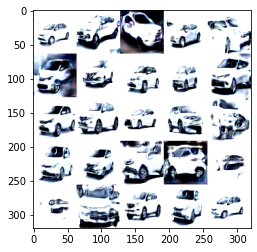

In [ ]:
img = get_sample_image(G, n_noise, n_samples=25)
imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


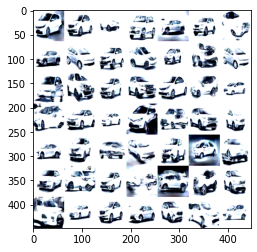

In [ ]:

img = get_sample_image(G, n_noise, n_samples=50)
imshow(img)

In [ ]:
import pandas as pd
tr_lo_df=pd.DataFrame(Dtrain_losses,columns=['Loss'])
ts_lo_df=pd.DataFrame(Gtrain_losses,columns=['Loss'])


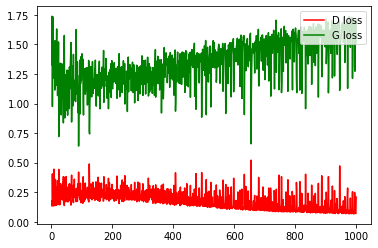

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(tr_lo_df.index+1,tr_lo_df['Loss'],color='red')
plt.plot(ts_lo_df.index+1,ts_lo_df['Loss'],color='green')

plt.legend(['D loss','G loss'], loc='upper right')
# plt.set_title("D-G Losses")
